In [1]:
suppressMessages({library(Seurat) 
library(SeuratData)
library(Signac)
library(EnsDb.Hsapiens.v86)
library(ggplot2)
library(cowplot)
library(GenomeInfoDb)
library(stringr)
library(patchwork)
library(SeuratDisk)
library(dplyr)})

In [2]:
results_dir = "../../../results/Fig6-Granja_PBMC_scATAC/Fig6-apply_seurat_label_transfer/"
figures_dir = "../../../results/Fig6-Granja_PBMC_scATAC/Fig6-apply_seurat_label_transfer/figures/"

### read the scATAC-seq data

In [3]:
counts <- Matrix::readMM("/project/scATAC_analysis/scATAcat_review/data/Granja2019/PBMC_D10T1/05_peaks_and_genesScore_matrix_ArchR/input_for_EpiAnno/ArchR_peakMatrix.mtx")
peaks <- read.table("/project/scATAC_analysis/scATAcat_review/data/Granja2019/PBMC_D10T1/05_peaks_and_genesScore_matrix_ArchR/input_for_EpiAnno/ArchR_peaks.tsv",sep="\t")
barcodes_df = read.table("/project/scATAC_analysis/scATAcat_review/data/Granja2019/PBMC_D10T1/05_peaks_and_genesScore_matrix_ArchR/ArchR_genescore_barcodes.tsv", sep="\t",  stringsAsFactors = TRUE,comment.char="")
barcodes_ =str_split_fixed(barcodes_df$V1, "#", 2)
barcodes <- as.data.frame(barcodes_)$V2
peaknames <- peaks$V1
colnames(counts) <- barcodes
rownames(counts) <- peaknames


In [4]:
chrom_assay <- CreateChromatinAssay(
  counts = counts,
  sep = c(":", "_"),
  fragments = '/project/scATAC_analysis/scATAcat_review/data/Granja2019/PBMC_D10T1/01_prepare_fragments_file/final_fragment_files/GSM4138893_scATAC_PBMC_D10T1_liftOverhg38_no_chrMt_sorted_fragments.tsv.gz',
  min.cells = 10,
  min.features = 200
)

pbmc.atac <- CreateSeuratObject(
  counts = chrom_assay,
  assay = "peaks"
)

Computing hash

Warning message:
"Keys should be one or more alphanumeric characters followed by an underscore, setting key from peaks to peaks_"


#### ATAC analysis

In [5]:
# get gene annotations for hg38
annotation <- GetGRangesFromEnsDb(ensdb = EnsDb.Hsapiens.v86)
seqlevels(annotation) <- paste0('chr', seqlevels(annotation))

Warning message:
"no function found corresponding to methods exports from 'BSgenome' for: 'releaseName'"
Warning message in .Seqinfo.mergexy(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .Seqinfo.mergexy(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .Seqinfo.mergexy(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .Seqinfo.mergexy(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .Seqinfo.mergexy(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .Seqinfo.mergexy(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppre

In [14]:
genome(annotation) <- "hg38"
Annotation(pbmc.atac) <- annotation

In [6]:
pbmc.atac

An object of class Seurat 
96091 features across 3082 samples within 1 assay 
Active assay: peaks (96091 features, 0 variable features)

In [7]:
#pbmc.atac@assayse first dimension as this is typically correlated with sequencing depth
pbmc.atac <- RunTFIDF(pbmc.atac)
pbmc.atac <- FindTopFeatures(pbmc.atac, min.cutoff = "q0")
pbmc.atac <- RunSVD(pbmc.atac)
pbmc.atac <- RunUMAP(pbmc.atac, reduction = "lsi", dims = 2:30, reduction.name = "umap.atac", reduction.key = "atacUMAP_")


Performing TF-IDF normalization

Running SVD

Scaling cell embeddings

Warning message:
"The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session"
22:03:28 UMAP embedding parameters a = 0.9922 b = 1.112

22:03:28 Read 3082 rows and found 29 numeric columns

22:03:28 Using Annoy for neighbor search, n_neighbors = 30

22:03:28 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

22:03:28 Writing NN index file to temp file /scratch/local/RtmpV7575N/file164483c20f96e

22:03:28 Searching Annoy index using 1 thread, search_k = 3000

22:03:29 Annoy recall = 100%

22:03:30 Co

In [15]:
## quantify gene activity
gene.activities <- GeneActivity(pbmc.atac)

# add gene activities as a new assay
pbmc.atac[["ACTIVITY"]] <- CreateAssayObject(counts = gene.activities)

# normalize gene activities
DefaultAssay(pbmc.atac) <- "ACTIVITY"
pbmc.atac <- NormalizeData(pbmc.atac)
pbmc.atac <- ScaleData(pbmc.atac, features = rownames(pbmc.atac))


Extracting gene coordinates

Extracting reads overlapping genomic regions

Centering and scaling data matrix



## ANNOTATION VIA REFERENCE 

- Annotations for scATAc-seq data is done via log transformed array


## scRNA-seq annotation

In [16]:
#source: https://atlas.fredhutch.org/data/nygc/multimodal/pbmc_multimodal.h5seurat
reference <- LoadH5Seurat("/project/scATAC_analysis/10X_PBMC_analysis/AnnotationQuestion/overlap_bulk_and_scATAC/sc_multiome/10X_PBMC_multiome/scRNAseq_integration_with_Seurat/reference/pbmc_multimodal.h5seurat")


Validating h5Seurat file

Initializing ADT with data

Adding counts for ADT

Adding variable feature information for ADT

Adding miscellaneous information for ADT

Initializing SCT with data

Adding counts for SCT

Adding variable feature information for SCT

Adding miscellaneous information for SCT

Adding reduction apca

Adding cell embeddings for apca

Adding feature loadings for apca

Adding miscellaneous information for apca

Adding reduction aumap

Adding cell embeddings for aumap

Adding miscellaneous information for aumap

Adding reduction pca

Adding cell embeddings for pca

Adding feature loadings for pca

Adding miscellaneous information for pca

Adding reduction spca

Adding cell embeddings for spca

Adding feature loadings for spca

Adding miscellaneous information for spca

Adding reduction umap

Adding cell embeddings for umap

Adding miscellaneous information for umap

Adding reduction wnn.umap

Adding cell embeddings for wnn.umap

Adding miscellaneous information for w

In [17]:
reference_plot_celltype.l1 = DimPlot(object = reference, reduction = "wnn.umap", group.by = "celltype.l1", label = T, label.size = 5, repel = TRUE) + NoLegend()

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



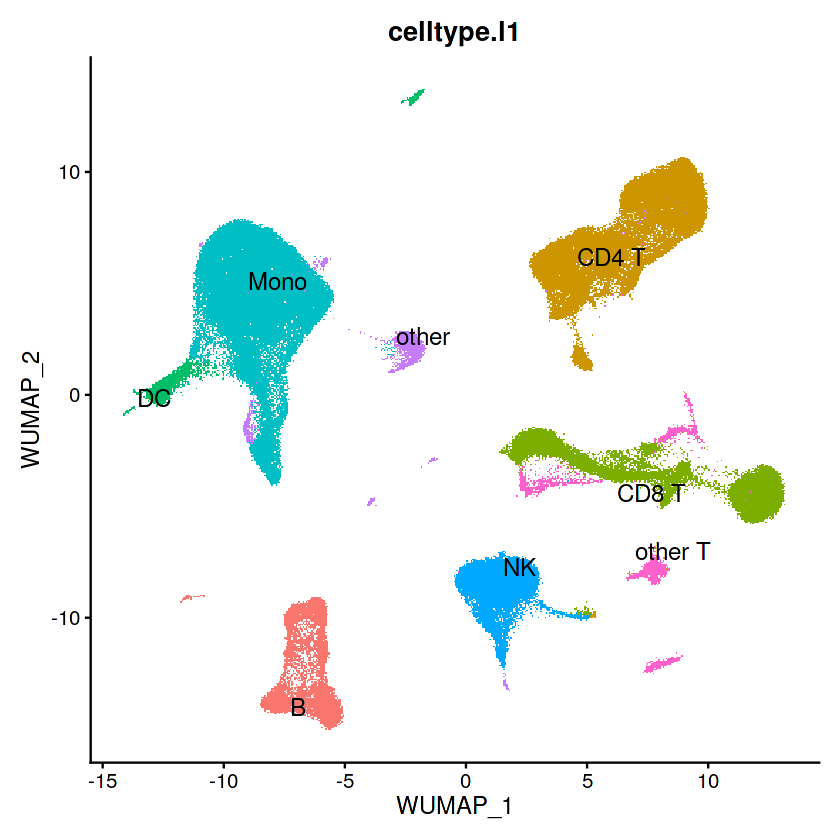

In [18]:
reference_plot_celltype.l1

## scATAC-seq annotation

#### it is recommended that gene activity matrix is only exposed to logtransformation: https://github.com/stuart-lab/signac/discussions/510 +  https://github.com/stuart-lab/signac/issues/433

In [19]:
reference

An object of class Seurat 
20957 features across 161764 samples within 2 assays 
Active assay: SCT (20729 features, 5000 variable features)
 1 other assay present: ADT
 6 dimensional reductions calculated: apca, aumap, pca, spca, umap, wnn.umap

In [20]:
logTransformedRNA <- CreateAssayObject(counts = reference@assays$SCT@counts)

In [21]:
reference[["logTransformedRNA"]] <- logTransformedRNA

In [22]:
DefaultAssay(reference) <- "logTransformedRNA"

In [23]:
reference

An object of class Seurat 
41686 features across 161764 samples within 3 assays 
Active assay: logTransformedRNA (20729 features, 0 variable features)
 2 other assays present: SCT, ADT
 6 dimensional reductions calculated: apca, aumap, pca, spca, umap, wnn.umap

In [24]:
reference <- NormalizeData(
  reference,
  normalization.method = "LogNormalize")

In [25]:
reference@assays$logTransformedRNA

Assay data with 20729 features for 161764 cells
First 10 features:
 AL627309.1, AL669831.5, LINC00115, FAM41C, NOC2L, KLHL17, PLEKHN1,
AL645608.8, HES4, ISG15 

In [26]:
reference <- FindVariableFeatures(reference)
reference <- ScaleData(reference)
reference <- RunPCA(reference)
reference <- RunUMAP(reference, dims = 1:30)


Centering and scaling data matrix

PC_ 1 
Positive:  RPS27, ETS1, RPS12, IL32, CD3E, LTB, TRBC2, CD3D, IL7R, CD3G 
	   CD2, TRAC, SYNE2, ARL4C, TXNIP, CD7, TCF7, CD247, CD69, SPOCK2 
	   TRBC1, GZMM, RORA, BCL11B, LINC00861, CXCR4, MALAT1, IKZF3, CD27, ITM2A 
Negative:  FCN1, LYZ, CST3, MNDA, CTSS, SERPINA1, CYBB, FGL2, FTL, NCF2 
	   S100A9, VCAN, GRN, PSAP, TYMP, SPI1, FTH1, TNFAIP2, CSTA, CD14 
	   AIF1, MPEG1, LST1, CLEC7A, CFD, S100A8, CD68, MS4A6A, CSF3R, NAMPT 
PC_ 2 
Positive:  MALAT1, CD79A, MS4A1, RALGPS2, IGHM, TNFRSF13C, LINC00926, RPS12, BANK1, IGHD 
	   VPREB3, CD22, CD79B, AFF3, PAX5, TCL1A, FCRL1, BCL11A, BLK, SWAP70 
	   P2RX5, FAM129C, HLA-DOB, COBLL1, ADAM28, RPS27, FCER2, LINC02397, HLA-DQA1, HLA-DQB1 
Negative:  TUBB1, CAVIN2, PF4, GP9, GNG11, PPBP, SPARC, PRKAR2B, TREML1, CLU 
	   CMTM5, MPIG6B, ACRBP, ITGA2B, C2orf88, TMEM40, CTTN, MYL9, PTCRA, TSC22D1 
	   AC147651.1, NRGN, HIST1H2AC, MAP3K7CL, CLDN5, MTURN, MYLK, MMD, RAB27B, HIST1H3H 
PC_ 3 
Positive:  PRF1, N

In [27]:
reference <- RunSPCA(reference, reduction.key = "SPC_logTr_", assay = 'logTransformedRNA', graph = 'wsnn')


Computing sPCA transformation

Warning message:
"Keys should be one or more alphanumeric characters followed by an underscore, setting key from SPC_logTr_ to SPClogTr_"
Warning message:
"All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to SPClogTr_"


In [28]:
reference <- FindNeighbors(
  object = reference,
  reduction = "spca",
  dims = 1:50,
  graph.name = "spca.annoy.neighbors", 
  k.param = 50,
  cache.index = TRUE,
  return.neighbor = TRUE,
  l2.norm = TRUE
)

Computing nearest neighbors

Only one graph name supplied, storing nearest-neighbor graph only



In [29]:
reference <- FindMultiModalNeighbors(
  reference, reduction.list = list("spca", "apca"), 
  dims.list = list(1:30, 1:18), modality.weight.name = "RNA.weight2", knn.graph.name = "wknn_logTr", snn.graph.name = "wsnn_logTr", weighted.nn.name = "weighted.nn_logTr",
)

Calculating cell-specific modality weights

Finding 20 nearest neighbors for each modality.

Calculating kernel bandwidths

Warning message in FindMultiModalNeighbors(reference, reduction.list = list("spca", :
"The number of provided modality.weight.name is not equal to the number of modalities. logTransformedRNA.weight ADT.weight are used to store the modality weights"
Finding multimodal neighbors

Constructing multimodal KNN graph

Constructing multimodal SNN graph



In [30]:
reference <- RunUMAP(reference, nn.name = "weighted.nn_logTr", reduction.name = "wnn.umap_logTr", reduction.key = "wnnUMAPlogTr_")


23:00:44 UMAP embedding parameters a = 0.9922 b = 1.112

23:00:46 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 20

23:00:52 Initializing from normalized Laplacian + noise (using irlba)

23:01:16 Commencing optimization for 200 epochs, with 5351556 positive edges

23:02:38 Optimization finished



In [31]:
reference <- FindClusters(reference, graph.name = "wsnn_logTr", algorithm = 3, resolution = 2, verbose = FALSE)

In [32]:
reference

An object of class Seurat 
41686 features across 161764 samples within 3 assays 
Active assay: logTransformedRNA (20729 features, 2000 variable features)
 2 other assays present: SCT, ADT
 7 dimensional reductions calculated: apca, aumap, pca, spca, umap, wnn.umap, wnn.umap_logTr

In [33]:
p1 <- DimPlot(reference, reduction = 'wnn.umap', label = TRUE, repel = TRUE, label.size = 2.5) + NoLegend()
p2 <- DimPlot(reference, reduction = 'wnn.umap', group.by = 'celltype.l2', label = TRUE, repel = TRUE, label.size = 2.5) + NoLegend()
p1 + p2

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Warning message:
"ggrepel: 6 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


In [35]:
results_dir

[1] "../../../results/Fig6-Granja_PBMC_scATAC/Fig6-apply_seurat_label_transfer/"

In [36]:
save.image(paste(results_dir , "WS/until_atac_annotation.RData", sep=''))

## process the query like reference

In [37]:
pbmc.atac

An object of class Seurat 
115698 features across 3082 samples within 2 assays 
Active assay: ACTIVITY (19607 features, 0 variable features)
 1 other assay present: peaks
 2 dimensional reductions calculated: lsi, umap.atac

In [38]:
pbmc.atac.anchors <- FindTransferAnchors(
  reference = reference,
  query = pbmc.atac,
  normalization.method = "LogNormalize",
  reference.reduction = "spca",
  dims = 1:50,
  k.filter = 30
)


Projecting cell embeddings

Finding neighborhoods

Finding anchors

	Found 455 anchors

Filtering anchors

	Retained 22 anchors



### through the standard pipeline we retained only a small number of anchors, so we will try with cca now.. for CCA, we need variable feature:

In [39]:
pbmc.atac <- NormalizeData(pbmc.atac, normalization.method = "LogNormalize", scale.factor = 10000)

In [40]:
pbmc.atac <- FindVariableFeatures(pbmc.atac, selection.method = "vst", nfeatures = 3000)

In [41]:
pbmc.atac

An object of class Seurat 
115698 features across 3082 samples within 2 assays 
Active assay: ACTIVITY (19607 features, 3000 variable features)
 1 other assay present: peaks
 2 dimensional reductions calculated: lsi, umap.atac

Warning message:
"Transformation introduced infinite values in continuous x-axis"
Warning message:
"Removed 262 rows containing missing values (geom_point)."


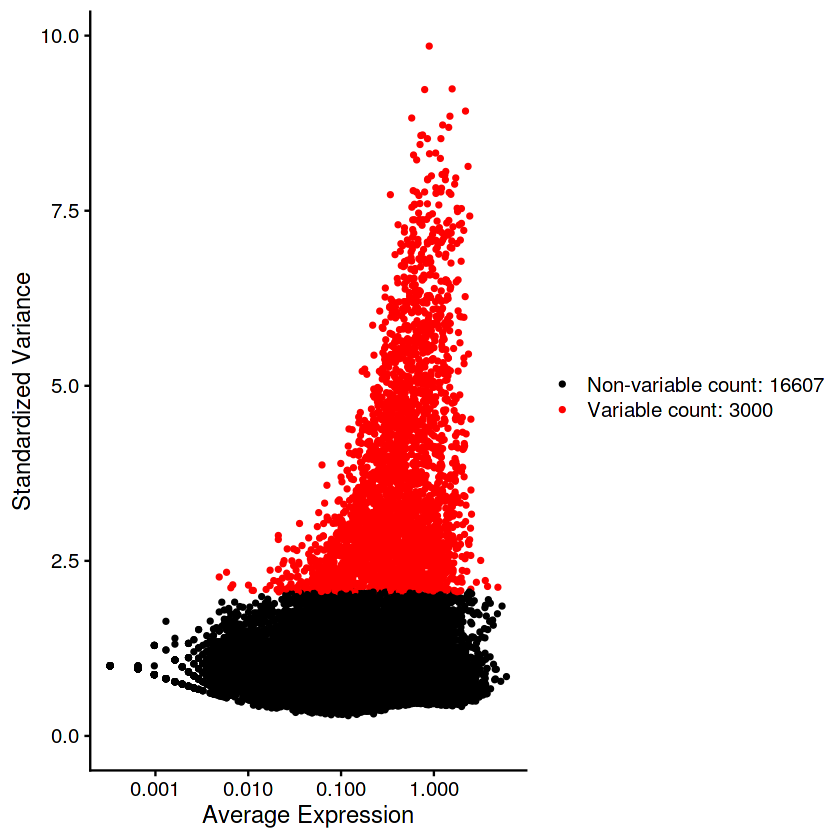

In [42]:
VariableFeaturePlot(pbmc.atac)

In [43]:
pbmc.atac.cca.anchors <- FindTransferAnchors(reference = reference, query = pbmc.atac, reduction = 'cca', dims = 1:30, 
                               reference.assay = 'logTransformedRNA', query.assay = 'ACTIVITY', normalization.method = 'LogNormalize')


Warning message in RunCCA.Seurat(object1 = reference, object2 = query, features = features, :
"Running CCA on different assays"
Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 14655 anchors

Filtering anchors

	Retained 4361 anchors



In [44]:

saveRDS(pbmc.atac.cca.anchors, paste(results_dir , "WS/pbmc_atac_cca_anchors.rds", sep=''))

In [45]:
pbmc.atac <- TransferData(
  anchorset = pbmc.atac.cca.anchors, 
  reference = reference,
  query = pbmc.atac,
  refdata = list(
    celltype.l1 = "celltype.l1",
    celltype.l2 = "celltype.l2",
    predicted_ADT = "ADT"),
    weight.reduction = 'cca'
)

Finding integration vectors

Finding integration vector weights

Predicting cell labels

Warning message:
"Keys should be one or more alphanumeric characters followed by an underscore, setting key from predictionscorecelltype.l1_ to predictionscorecelltypel1_"
Predicting cell labels

Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"
Warning message:
"Keys should be one or more alphanumeric characters followed by an underscore, setting key from predictionscorecelltype.l2_ to predictionscorecelltypel2_"
Transfering 228 features onto reference data

Warning message:
"Keys should be one or more alphanumeric characters followed by an underscore, setting key from predicted_ADT_ to predictedADT_"


In [46]:
pbmc.atac <- IntegrateEmbeddings(
  anchorset = pbmc.atac.cca.anchors,
  reference = reference,
  query = pbmc.atac, 
  new.reduction.name = "ref.cca",
  reductions = "cca",
)


Integrating dataset 2 with reference dataset

Finding integration vectors

Integrating data



## export resulting annotations

In [47]:
atac_rna_predictions = data.frame(pbmc.atac@meta.data$predicted.celltype.l1, row.names =names(pbmc.atac$nCount_ACTIVITY) )

In [66]:
table(data.frame(pbmc.atac@meta.data$predicted.celltype.l1, row.names =names(pbmc.atac$nCount_ACTIVITY) ))


      B   CD4 T   CD8 T      DC    Mono      NK   other other T 
    291     874     390      34    1241     189       4      59 

In [48]:
head(atac_rna_predictions)

pbmc.atac.meta.data.predicted.celltype.l1
GTGTGATCAAGGAAGA-1 CD8 T                                    
GCACGCATCCAGGTCG-1 CD4 T                                    
GGGAACAGTACAAGCG-1 CD8 T                                    
AAAGATGTCTCTGAGA-1 CD4 T                                    
CTAGGATGTCTCTGCT-1 CD4 T                                    
CACTAAGGTTCCCGGA-1 CD4 T

In [49]:
colnames(atac_rna_predictions) = c('atac.l1.predictions')

In [59]:
head(atac_rna_predictions)

atac.l1.predictions
GTGTGATCAAGGAAGA-1 CD8 T              
GCACGCATCCAGGTCG-1 CD4 T              
GGGAACAGTACAAGCG-1 CD8 T              
AAAGATGTCTCTGAGA-1 CD4 T              
CTAGGATGTCTCTGCT-1 CD4 T              
CACTAAGGTTCCCGGA-1 CD4 T

In [67]:
write.csv(atac_rna_predictions,paste(results_dir , "Granja2019_PBMC_seurat_label_transfer_annotations.csv", sep='') )

In [54]:
pbmc.atac

An object of class Seurat 
115965 features across 3082 samples within 5 assays 
Active assay: ACTIVITY (19607 features, 3000 variable features)
 4 other assays present: peaks, prediction.score.celltype.l1, prediction.score.celltype.l2, predicted_ADT
 3 dimensional reductions calculated: lsi, umap.atac, ref.cca

In [55]:
atac_plot <- DimPlot(pbmc.atac, reduction = 'umap.atac', group.by = 'predicted.celltype.l1', label = TRUE, 
              repel = TRUE, label.size = 4) #+ NoLegend()

In [56]:
reference_plot <- DimPlot(reference, reduction = "wnn.umap_logTr", group.by = "celltype.l1", label = TRUE, label.size = 4, repel = TRUE) 
ggsave(paste(figures_dir,"reference_plot.png", sep=''))

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Saving 6.67 x 6.67 in image



In [57]:
atac_plot <- atac_plot + scale_fill_continuous(guide = guide_legend()) +
    theme(legend.position="bottom")

ggsave(paste(figures_dir,"atac_label_transfer.png", sep=''))

Saving 6.67 x 6.67 in image



In [58]:
reference_plot + scale_fill_continuous(guide = guide_legend()) +
    theme(legend.position="bottom")
ggsave(paste(figures_dir,"reference_label_transfer.png", sep=''))


Saving 6.67 x 6.67 in image



## export gene activity matrix for marker gene baased annottaion

In [60]:
write.csv(as.data.frame(gene.activities), paste(results_dir,"PBMC_atac_gene_activities.csv", sep=''))

In [61]:
write.csv(pbmc.atac@meta.data, paste(results_dir,"pbmc_atac_metaData_w_predictions.csv",sep=''))

save.image(paste(results_dir , "WS/completed.RData", sep=''))

In [64]:
saveRDS(pbmc.atac , paste(results_dir ,"WS/pbmc_atac.RDS", sep=''))    